# KE5105 - Building Electrical Consumption Forecasting

# Pre-processing 1 - De-trend, de-seasonalise data

## Summary of Findings
* to be updated

## Load libraries

In [1]:
import os
os.chdir(os.path.join(os.path.sep, 'home', 'tkokkeng', 'Documents', 'KE5105', 'ETL'))
os.getcwd()

'/home/tkokkeng/Documents/KE5105/ETL'

In [2]:
import sys
if os.path.join(os.getcwd(), 'source') not in sys.path:
    sys.path.append(os.path.join(os.getcwd(), 'source'))
sys.path

['/home/tkokkeng/Documents/KE5105/ETL',
 '/home/tkokkeng/python/python367/tsfvenv/lib',
 '/home/tkokkeng/Documents/KE5105/ETL/source',
 '',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6/site-packages',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python36.zip',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6/lib-dynload',
 '/usr/lib/python3.6',
 '/home/tkokkeng/.local/lib/python3.6/site-packages',
 '/usr/local/lib/python3.6/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6/site-packages/IPython/extensions',
 '/home/tkokkeng/.ipython']

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
import myUtilities as mu
import pickle
import statsmodels.api as sm

Using TensorFlow backend.


## Load data for building AS5

In [4]:
as5_train = mu.load_data_by_bldg(['AS5'], 'imputed_train')

In [5]:
as5_train[0][1].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31616 entries, 2015-06-12 08:00:00 to 2017-03-31 23:30:00
Data columns (total 17 columns):
PWMMainIC                         30018 non-null float64
PWMEXTAS4ExBldg                   30018 non-null float64
PWMAS4LanguageCenter              30018 non-null float64
PWMCANTEEN                        30018 non-null float64
PWMStreetLight                    30018 non-null float64
BTUAS5                            30029 non-null float64
PWMMainIC_30min_avg               29985 non-null float64
PWMEXTAS4ExBldg_30min_avg         29985 non-null float64
PWMAS4LanguageCenter_30min_avg    29985 non-null float64
PWMCANTEEN_30min_avg              29985 non-null float64
PWMStreetLight_30min_avg          29985 non-null float64
BTUAS5_30min_avg                  29998 non-null float64
PWM_sumadd                        29985 non-null float64
PWM_sumsubtract                   29985 non-null float64
PWM_30min_avg                     30027 non-null float64
B

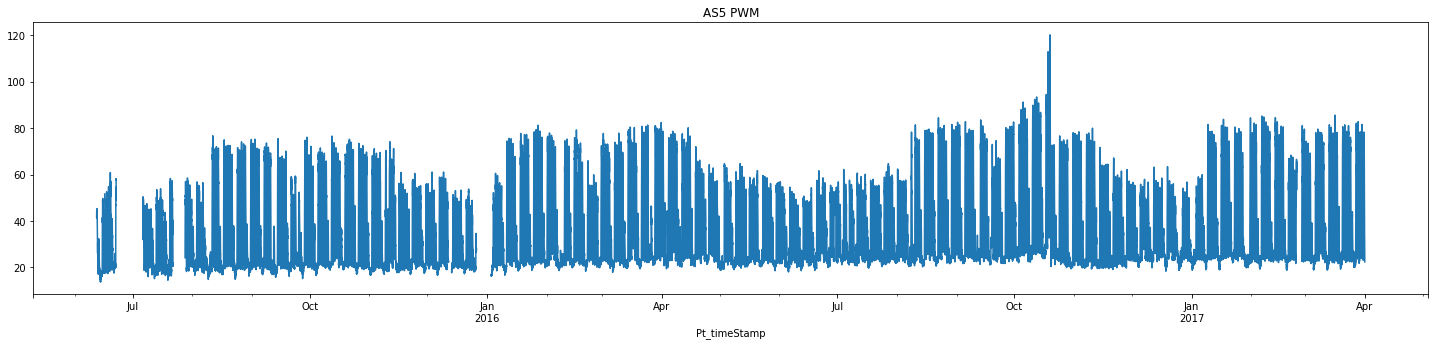

In [6]:
as5_train_df = as5_train[0][1]
as5_train_df['PWM_30min_avg'].plot(figsize=(25, 5), title='AS5 PWM')

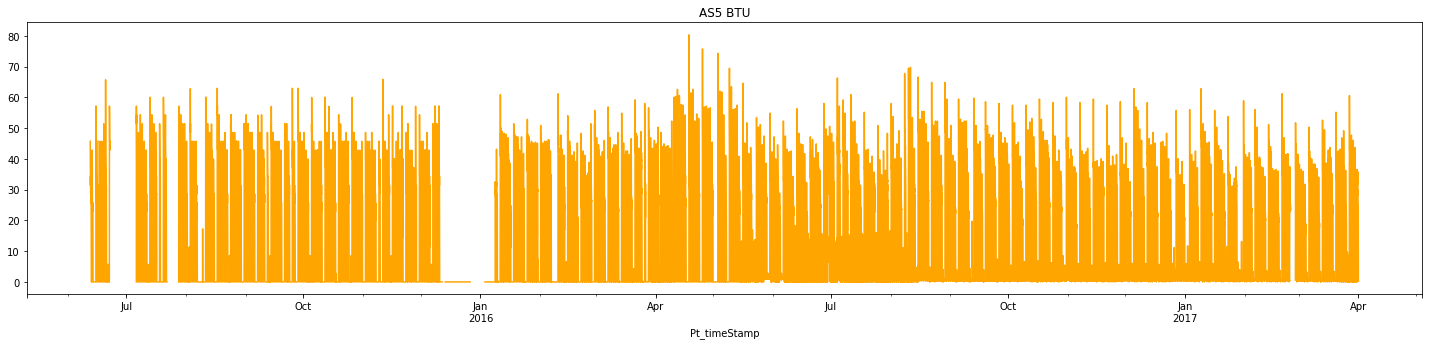

In [7]:
as5_train_df['BTU_30min_avg'].plot(figsize=(25, 5), title='AS5 BTU', color='orange')

## Split a validation set out from the train set

In [8]:
as5_train_split_df = as5_train_df[:20000]
as5_val_split_df = as5_train_df[20000:]

In [9]:
print('train split = %s\nvalidation split = %s' % (as5_train_split_df.shape, as5_val_split_df.shape))

train split = (20000, 17)
validation split = (11616, 17)


## Check for the largest contiguous subset of non-Nan data

### For training data

In [10]:
as5_PWM_notnan_df = as5_train_split_df['PWM_30min_avg'].to_frame()
as5_PWM_notnan_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20000 entries, 2015-06-12 08:00:00 to 2016-08-01 23:30:00
Data columns (total 1 columns):
PWM_30min_avg    18551 non-null float64
dtypes: float64(1)
memory usage: 312.5 KB


In [11]:
pd.isna(as5_PWM_notnan_df['PWM_30min_avg'])[:10]

Pt_timeStamp
2015-06-12 08:00:00    False
2015-06-12 08:30:00    False
2015-06-12 09:00:00    False
2015-06-12 09:30:00    False
2015-06-12 10:00:00    False
2015-06-12 10:30:00    False
2015-06-12 11:00:00    False
2015-06-12 11:30:00    False
2015-06-12 12:00:00    False
2015-06-12 12:30:00    False
Name: PWM_30min_avg, dtype: bool

In [12]:
as5_PWM_notnan_df['na_cumsum'] = pd.isna(as5_PWM_notnan_df['PWM_30min_avg']).cumsum()

In [13]:
as5_PWM_notnan_df.loc[pd.isna(as5_PWM_notnan_df['PWM_30min_avg']), :].index

DatetimeIndex(['2015-06-16 08:30:00', '2015-06-16 09:00:00',
               '2015-06-16 09:30:00', '2015-06-16 10:00:00',
               '2015-06-16 10:30:00', '2015-06-16 11:00:00',
               '2015-06-16 11:30:00', '2015-06-16 12:00:00',
               '2015-06-16 12:30:00', '2015-06-22 12:30:00',
               ...
               '2016-06-30 01:00:00', '2016-06-30 01:30:00',
               '2016-06-30 02:00:00', '2016-06-30 02:30:00',
               '2016-06-30 03:00:00', '2016-06-30 03:30:00',
               '2016-06-30 04:00:00', '2016-06-30 04:30:00',
               '2016-06-30 05:00:00', '2016-06-30 05:30:00'],
              dtype='datetime64[ns]', name='Pt_timeStamp', length=1449, freq=None)

In [14]:
as5_PWM_notnan_df.drop(as5_PWM_notnan_df.loc[pd.isna(as5_PWM_notnan_df['PWM_30min_avg']), :].index, inplace=True)
as5_PWM_notnan_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 18551 entries, 2015-06-12 08:00:00 to 2016-08-01 23:30:00
Data columns (total 2 columns):
PWM_30min_avg    18551 non-null float64
na_cumsum        18551 non-null int64
dtypes: float64(1), int64(1)
memory usage: 434.8 KB


In [15]:
as5_PWM_notnan_df.head()

,PWM_30min_avg,na_cumsum
Pt_timeStamp,,
2015-06-12 08:00:00,41.68,0
2015-06-12 08:30:00,42.18,0
2015-06-12 09:00:00,43.57,0
2015-06-12 09:30:00,44.75,0
2015-06-12 10:00:00,41.18,0


In [16]:
df = as5_PWM_notnan_df.groupby('na_cumsum').size().to_frame()
df.columns = ['size']
df

,size
na_cumsum,
0,193
9,287
669,760
965,6568
1042,621
1411,2165
1417,264
1426,6121
1449,1572


In [17]:
[ as5_PWM_notnan_df.groupby('na_cumsum').groups[i].min() for i in df.index ]
#.as5_PWM_notnan_df.groupby('na_cumsum').groups[].min()

[Timestamp('2015-06-12 08:00:00'),
 Timestamp('2015-06-16 13:00:00'),
 Timestamp('2015-07-06 06:30:00'),
 Timestamp('2015-07-28 06:30:00'),
 Timestamp('2015-12-13 17:00:00'),
 Timestamp('2016-01-03 08:00:00'),
 Timestamp('2016-02-17 13:30:00'),
 Timestamp('2016-02-23 06:00:00'),
 Timestamp('2016-06-30 06:00:00')]

In [18]:
df['start_time'] = [ as5_PWM_notnan_df.groupby('na_cumsum').groups[i].min() for i in df.index ]
df

,size,start_time
na_cumsum,,
0,193,2015-06-12 08:00:00
9,287,2015-06-16 13:00:00
669,760,2015-07-06 06:30:00
965,6568,2015-07-28 06:30:00
1042,621,2015-12-13 17:00:00
1411,2165,2016-01-03 08:00:00
1417,264,2016-02-17 13:30:00
1426,6121,2016-02-23 06:00:00
1449,1572,2016-06-30 06:00:00


In [19]:
pd.Timestamp('2015-07-28 06:30:00') + pd.Timedelta('30 min') * 6567

Timestamp('2015-12-12 02:00:00')

In [20]:
as5_train_split_df.loc['2015-07-28 06:30:00':pd.Timestamp('2015-07-28 06:30:00') + pd.Timedelta('30 min') * 6567, 'PWM_30min_avg'].isna().any()

False

### For validation data

In [21]:
as5_val_PWM_notnan_df = as5_val_split_df['PWM_30min_avg'].to_frame()
as5_val_PWM_notnan_df['na_cumsum'] = pd.isna(as5_val_PWM_notnan_df['PWM_30min_avg']).cumsum()
as5_val_PWM_notnan_df.drop(as5_val_PWM_notnan_df.loc[pd.isna(as5_val_PWM_notnan_df['PWM_30min_avg']), :].index, inplace=True)
df_val = as5_val_PWM_notnan_df.groupby('na_cumsum').size().to_frame()
df_val['start_time'] = [ as5_val_PWM_notnan_df.groupby('na_cumsum').groups[i].min() for i in df_val.index ]
df_val

,0,start_time
na_cumsum,,
0,5807,2016-08-02 00:00:00
4,356,2016-12-01 01:30:00
10,470,2016-12-08 14:30:00
19,3271,2016-12-18 14:00:00
140,1572,2017-02-27 06:00:00


In [22]:
as5_val_split_df.loc['2016-08-02 00:00:00':pd.Timestamp('2016-08-02 00:00:00') + pd.Timedelta('30 min') * 5806, 'PWM_30min_avg'].isna().any()

False

## Apply the Classical Decomposition Method

### For training data

### Cycle of 1 day

In [23]:
decomp = sm.tsa.seasonal_decompose(as5_train_split_df.loc['2015-07-28 06:30:00':pd.Timestamp('2015-07-28 06:30:00') + pd.Timedelta('30 min') * 6567, 'PWM_30min_avg'], model='additive', two_sided=True, freq=48)

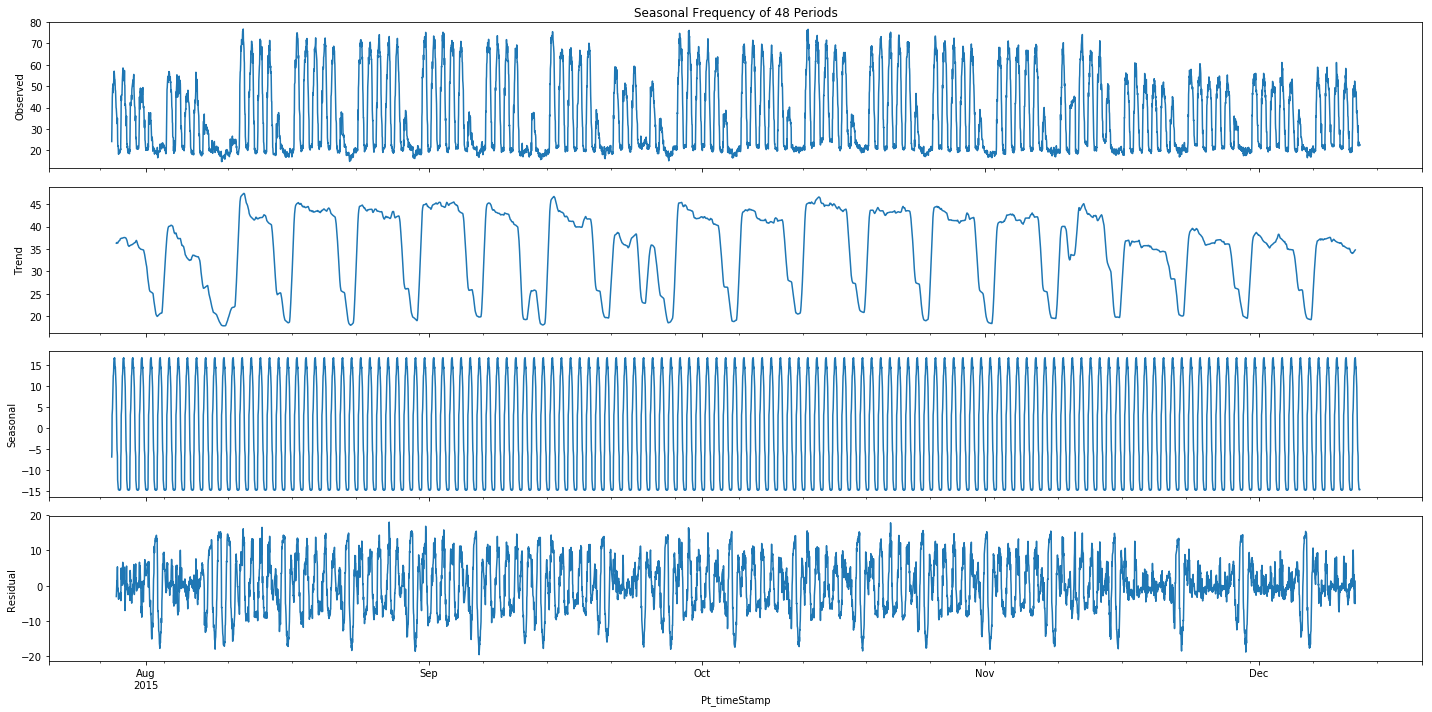

In [24]:
fig = decomp.plot()
fig.set_size_inches(20, 10)
fig.get_axes()[0].set_title('Seasonal Frequency of ' + str(48) + ' Periods')
plt.tight_layout()

The trend shows changes in the daily cycles over time. We see clearly the differences between weekday and weekend usage.

### Cycle of 7 days

In [26]:
decomp336 = sm.tsa.seasonal_decompose(as5_train_split_df.loc['2015-07-28 06:30:00':pd.Timestamp('2015-07-28 06:30:00') + pd.Timedelta('30 min') * 6567,
                                      'PWM_30min_avg'], model='additive', two_sided=True, freq=336)

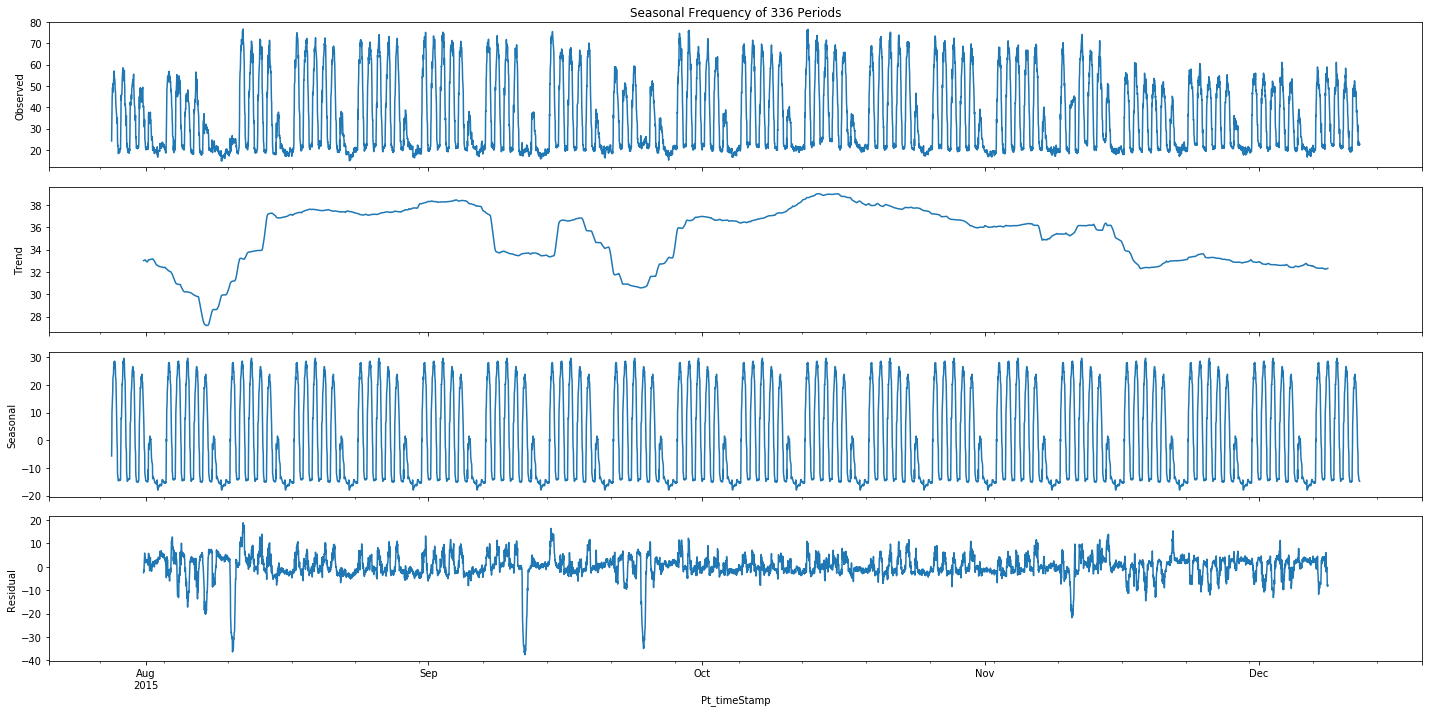

In [27]:
fig = decomp336.plot()
fig.set_size_inches(20, 10)
fig.get_axes()[0].set_title('Seasonal Frequency of ' + str(336) + ' Periods')
plt.tight_layout()

The trend shows the changes in weekly cycles over time. We see the differences between the periods in the academic calendar. As we are concern more with longer duration trends which may not be learned by the neural network, we will continue the analysis using the week cycle for decomposition.

### For validation data

### Cycle of 7 days

In [28]:
decomp336_val = sm.tsa.seasonal_decompose(as5_val_split_df.loc['2016-08-02 00:00:00':pd.Timestamp('2016-08-02 00:00:00') + pd.Timedelta('30 min') * 5806, 'PWM_30min_avg'],
                                          model='additive', two_sided=True, freq=336)

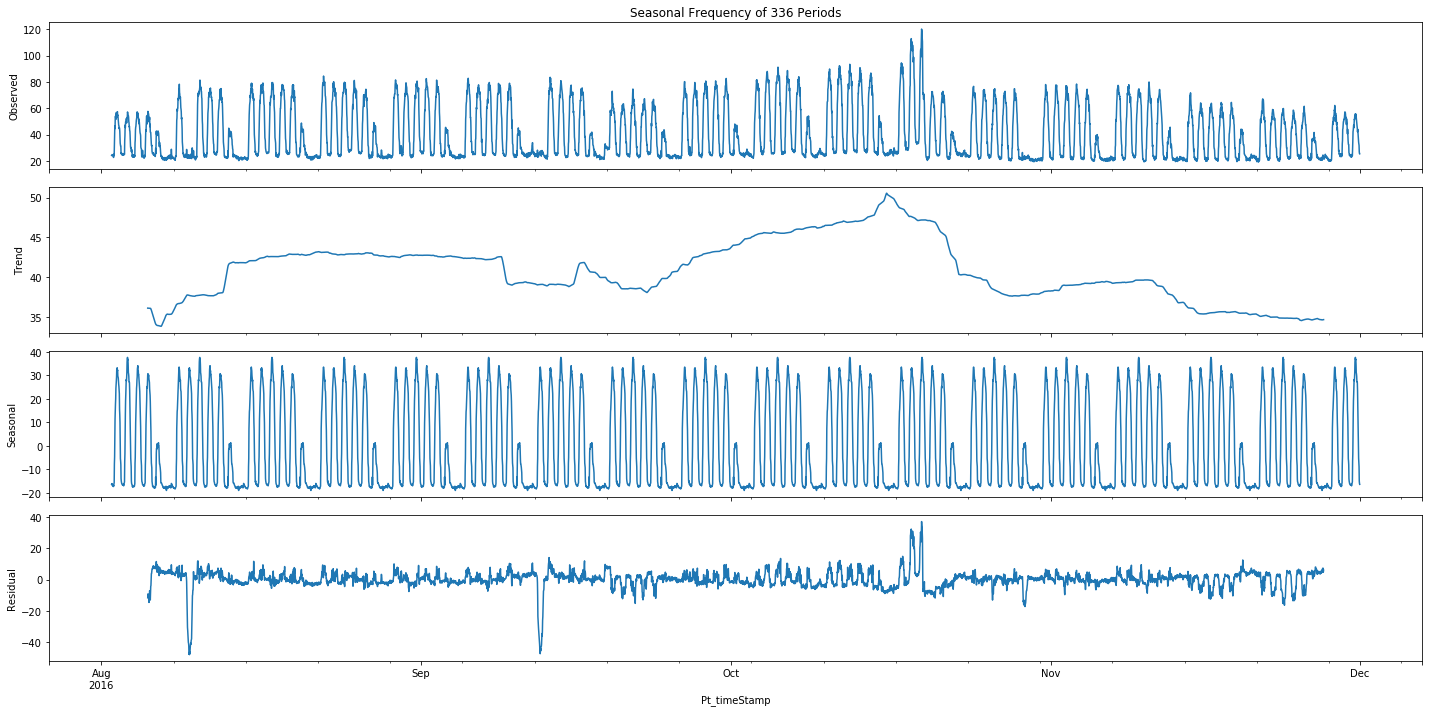

In [29]:
fig = decomp336_val.plot()
fig.set_size_inches(20, 10)
fig.get_axes()[0].set_title('Seasonal Frequency of ' + str(336) + ' Periods')
plt.tight_layout()

In [30]:
(decomp336_val.seasonal.max() - decomp336_val.seasonal.min()) / (decomp336.seasonal.max() - decomp336.seasonal.min())

1.1856087916020435

In [31]:
# min_val = decomp336_val.seasonal.min()
# max_val = decomp336_val.seasonal.max()
# range_val = max_val - min_val
# min = decomp336.seasonal.min()
# max = decomp336.seasonal.max()
# range = max - min

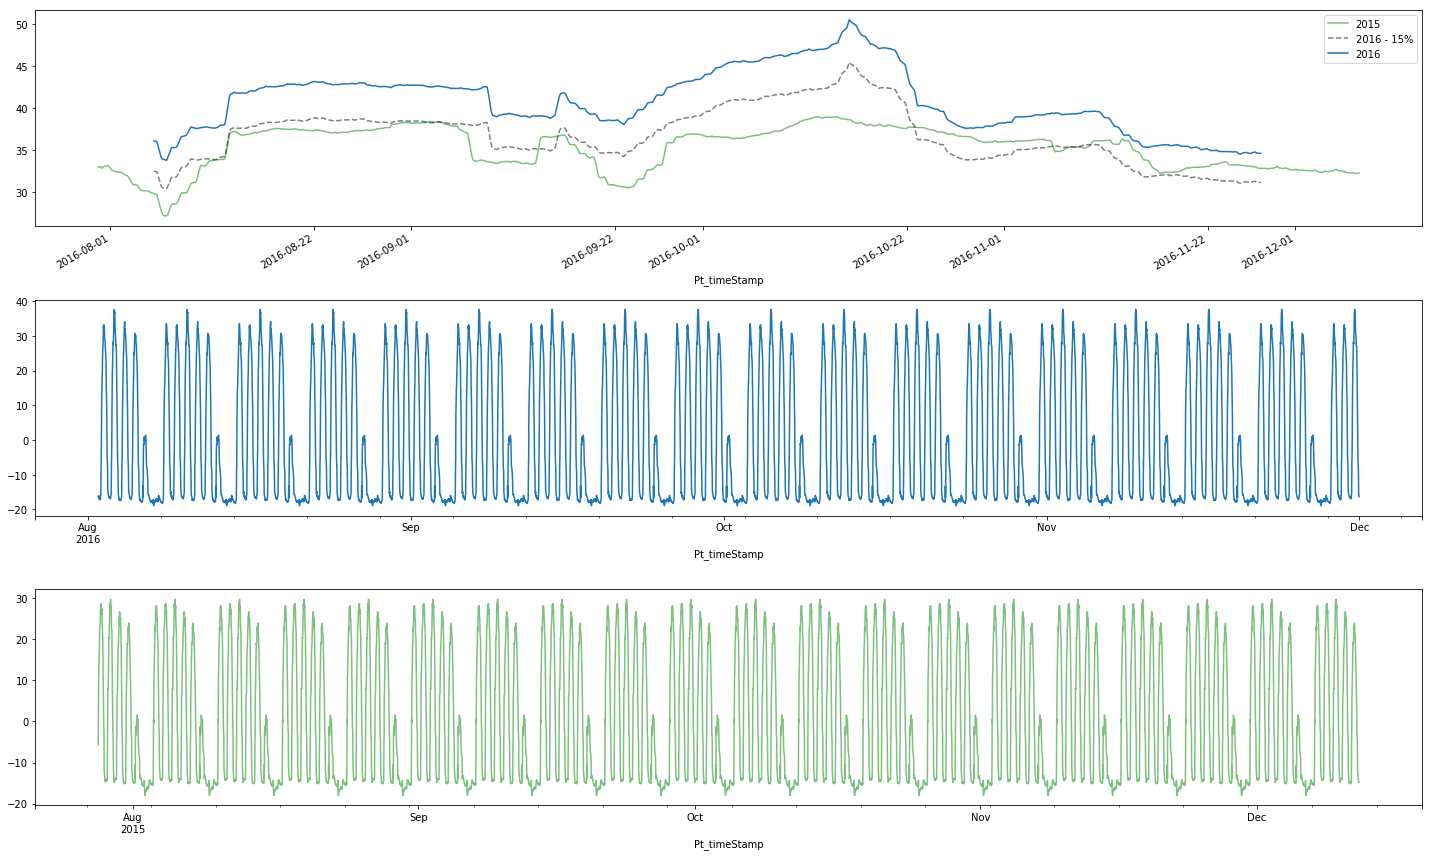

In [32]:
plt.figure(figsize=(20, 12))
plt.subplot(311)
plt.plot(decomp336.trend.index + pd.Timedelta('365 days'), decomp336.trend, label='2015', color='green', alpha=.5)
# plt.plot(decomp336.trend.index + pd.Timedelta('365 days'), decomp336.trend * 1.15, label='2015 + 15%', color='black', alpha=.5, linestyle='--')
# decomp336_val.trend.plot(label='2016')
(decomp336_val.trend * .9).plot(label='2016 - 15%', color='black', alpha=.5, linestyle='--')
decomp336_val.trend.plot(label='2016')
plt.legend()
plt.subplot(312)
decomp336_val.seasonal.plot()
plt.subplot(313)
decomp336.seasonal.plot(color='green', alpha=.5)
plt.tight_layout()

### Try the multiplicative model for decomposition

In [33]:
decomp336_mult = sm.tsa.seasonal_decompose(as5_train_split_df.loc['2015-07-28 06:30:00':pd.Timestamp('2015-07-28 06:30:00') + pd.Timedelta('30 min') * 6567, 'PWM_30min_avg'],
                                      model='multiplicative', two_sided=True, freq=336)

In [34]:
decomp336_val_mult = sm.tsa.seasonal_decompose(as5_val_split_df.loc['2016-08-02 00:00:00':pd.Timestamp('2016-08-02 00:00:00') + pd.Timedelta('30 min') * 5806, 'PWM_30min_avg'],
                                               model='multiplicative', two_sided=True, freq=336)

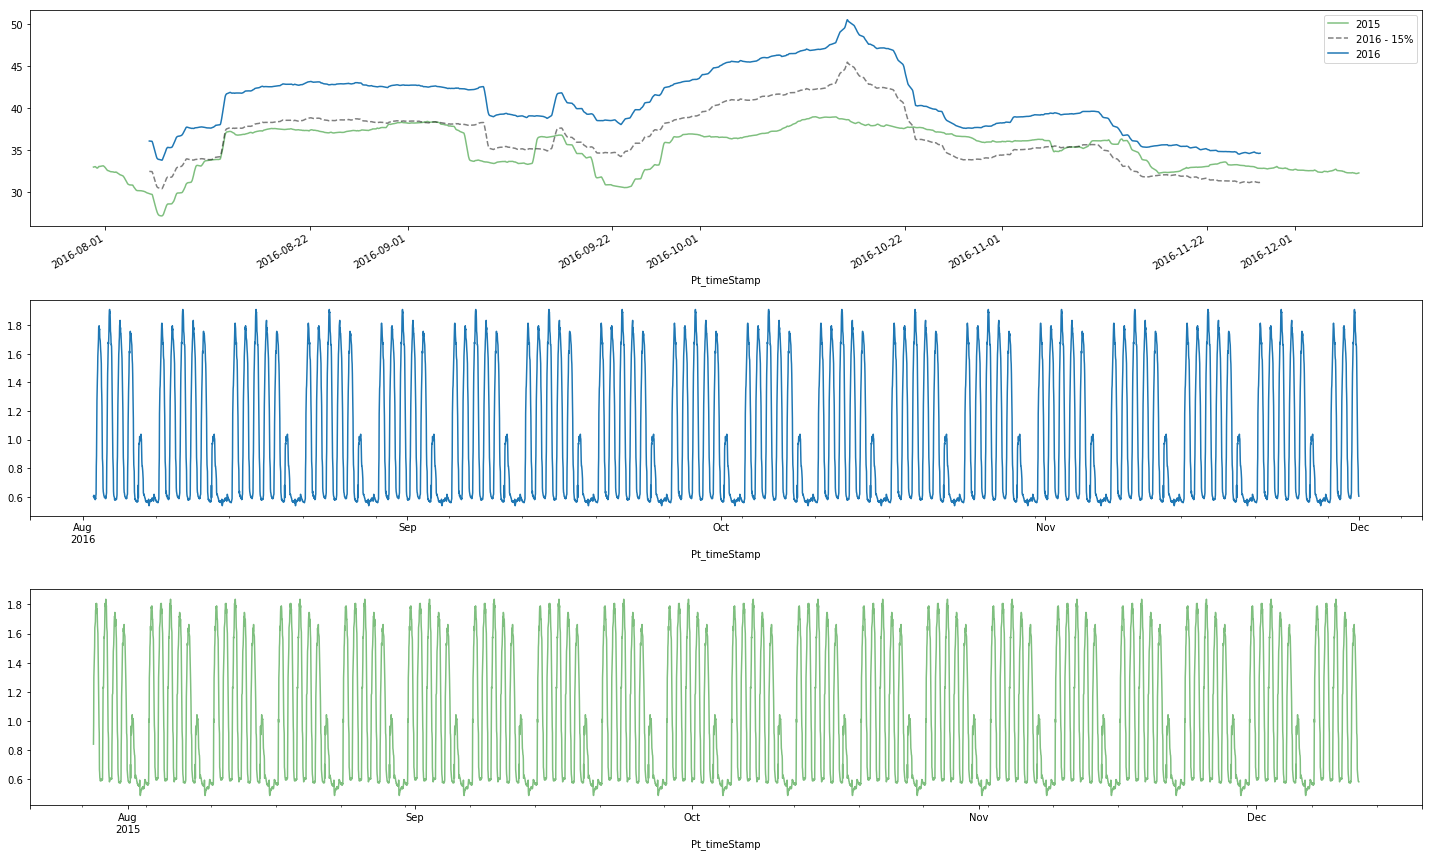

In [35]:
plt.figure(figsize=(20, 12))
plt.subplot(311)
plt.plot(decomp336_mult.trend.index + pd.Timedelta('365 days'), decomp336_mult.trend, label='2015', color='green', alpha=.5)
# plt.plot(decomp336_mult.trend.index + pd.Timedelta('365 days'), decomp336_mult.trend * 1.15, label='2015 + 15%', color='black', alpha=.5, linestyle='--')
(decomp336_val_mult.trend * .9).plot(label='2016 - 15%', color='black', alpha=.5, linestyle='--')
decomp336_val_mult.trend.plot(label='2016')
plt.legend()
plt.subplot(312)
decomp336_val_mult.seasonal.plot()
plt.subplot(313)
decomp336_mult.seasonal.plot(color='green', alpha=.5)
plt.tight_layout()

## Transform the data by detrending

### Assume there is an increase in peak usage by x% year on year. For the training data from Jul 15 to Dec 16, the data between Aug 16 and Dec 16 needs to be detrended.

In [36]:
# # De-trend to 2016 data.
# detrended = as5_val_split_df.loc[:, 'PWM_30min_avg']
# min = detrended.min()
# detrended = (detrended - min) * .95 + as5_train_split_df['PWM_30min_avg'][-1]

In [37]:
as5_train_df.loc['2016-07-31 22:00:00': '2016-08-01 02:00:00':, 'PWM_30min_avg']

Pt_timeStamp
2016-07-31 22:00:00    23.130000
2016-07-31 22:30:00    24.160000
2016-07-31 23:00:00    23.370000
2016-07-31 23:30:00    23.250461
2016-08-01 00:00:00    23.111145
2016-08-01 00:30:00    23.000000
2016-08-01 01:00:00    23.090000
2016-08-01 01:30:00    22.540000
2016-08-01 02:00:00    23.280000
Name: PWM_30min_avg, dtype: float64

In [38]:
detrended = as5_train_df.loc['2016-08-01 00:00:00':, 'PWM_30min_avg']
# min = detrended.min()
min = detrended[0]
# detrended = (detrended - min) * .95 + as5_train_df['PWM_30min_avg']['2016-07-31 23:30:00']
detrended = (detrended - min) * .95 + min
detrended = pd.concat([as5_train_df.loc[:'2016-07-31 23:30:00', 'PWM_30min_avg'], detrended])

In [39]:
detrended['2016-07-31 22:00:00': '2016-08-01 02:00:00']

Pt_timeStamp
2016-07-31 22:00:00    23.130000
2016-07-31 22:30:00    24.160000
2016-07-31 23:00:00    23.370000
2016-07-31 23:30:00    23.250461
2016-08-01 00:00:00    23.111145
2016-08-01 00:30:00    23.005557
2016-08-01 01:00:00    23.091057
2016-08-01 01:30:00    22.568557
2016-08-01 02:00:00    23.271557
Name: PWM_30min_avg, dtype: float64

In [40]:
as5_train_split_df = detrended[:20000]
as5_val_split_df = detrended[20000:]

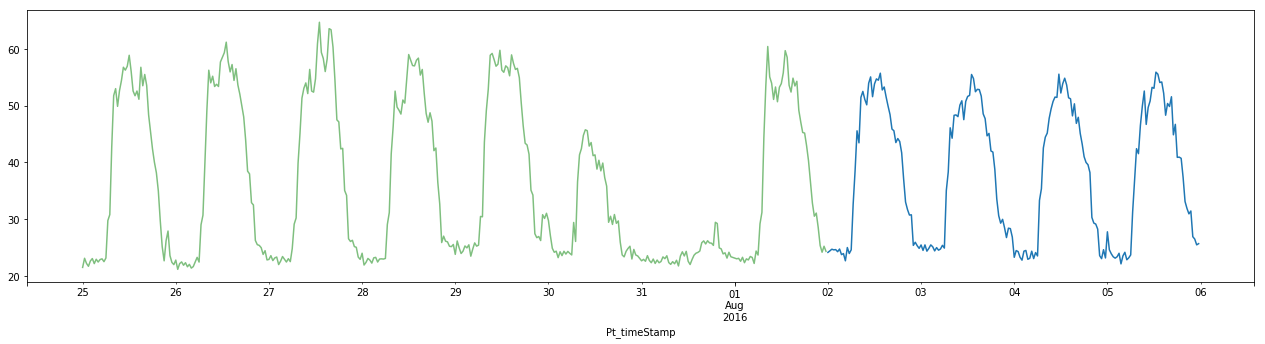

In [41]:
plt.figure(figsize=(22, 5))
as5_train_split_df['2016-07-25':].plot(color='green', alpha=.5)
as5_val_split_df[:'2016-08-05'].plot()

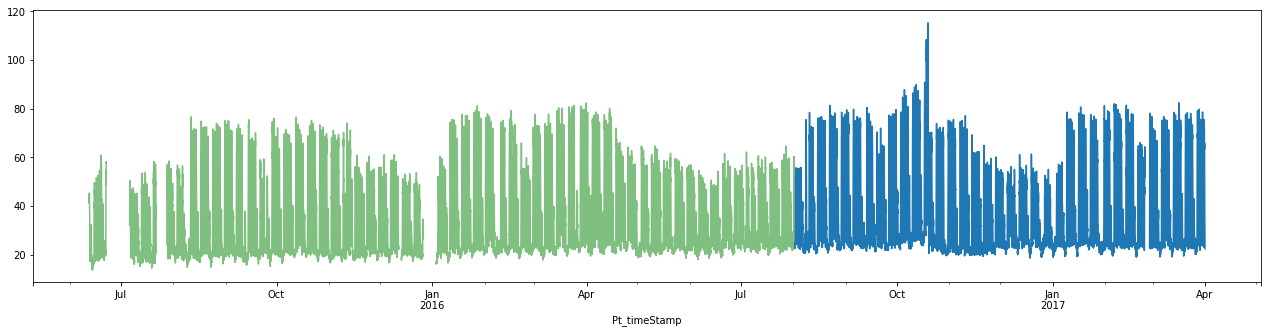

In [42]:
plt.figure(figsize=(22, 5))
as5_train_split_df.plot(color='green', alpha=.5)
as5_val_split_df.plot()

The detrended data from Aug 16 to Apr 17 looks similar to 2015-16 data except for **Sep-Oct 16** which has higher peaks.

In [43]:
decomp336_val_detrended = sm.tsa.seasonal_decompose(detrended['2016-08-02 00:00:00':pd.Timestamp('2016-08-02 00:00:00') + pd.Timedelta('30 min') * 5806],
                                              model='additive', two_sided=True, freq=336)

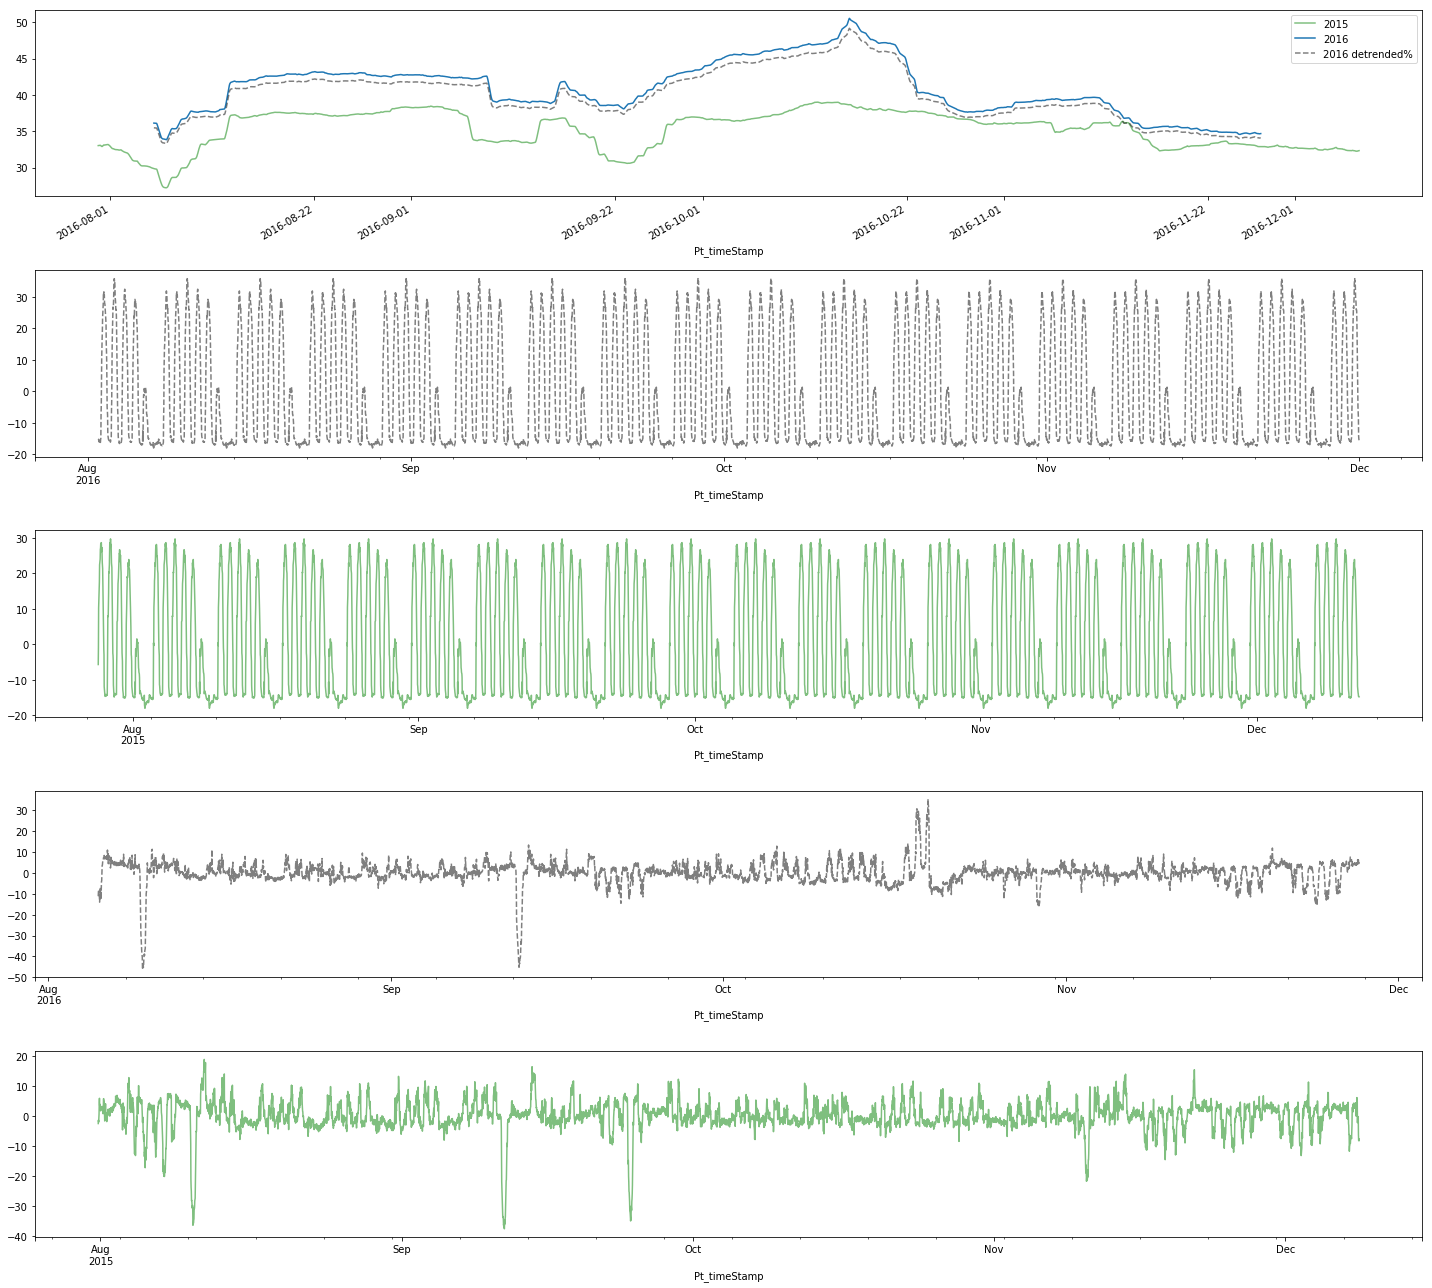

In [44]:
plt.figure(figsize=(20, 18))
plt.subplot(511)
plt.plot(decomp336.trend.index + pd.Timedelta('365 days'), decomp336.trend, label='2015', color='green', alpha=.5)
# plt.plot(decomp336_mult.trend.index + pd.Timedelta('365 days'), decomp336_mult.trend * 1.15, label='2015 + 15%', color='black', alpha=.5, linestyle='--')
decomp336_val.trend.plot(label='2016')
decomp336_val_detrended.trend.plot(label='2016 detrended%', color='black', alpha=.5, linestyle='--')
plt.legend()
plt.subplot(512)
decomp336_val_detrended.seasonal.plot(color='black', alpha=.5, linestyle='--')
plt.subplot(513)
decomp336.seasonal.plot(color='green', alpha=.5)
plt.subplot(514)
decomp336_val_detrended.resid.plot(color='black', alpha=.5, linestyle='--')
plt.subplot(515)
decomp336.resid.plot(color='green', alpha=.5)
plt.tight_layout()

For the period Aug-Dec, 2016 vs 2015 data after detrending still looks different.

In [46]:
decomp336_1 = sm.tsa.seasonal_decompose(as5_train_df.loc['2016-01-03 08:00:00':pd.Timestamp('2016-01-03 08:00:00') + pd.Timedelta('30 min') * 2164, 'PWM_30min_avg'],
                                        model='additive', two_sided=True, freq=336)

In [47]:
decomp336_val_1 = sm.tsa.seasonal_decompose(as5_train_df.loc['2017-01-03 08:00:00':pd.Timestamp('2017-01-03 08:00:00') + pd.Timedelta('30 min') * 2164, 'PWM_30min_avg'],
                                            model='additive', two_sided=True, freq=336)

In [48]:
decomp336_val_detrended1 = sm.tsa.seasonal_decompose(detrended['2017-01-03 08:00:00':pd.Timestamp('2017-01-03 08:00:00') + pd.Timedelta('30 min') * 2164],
                                              model='additive', two_sided=True, freq=336)

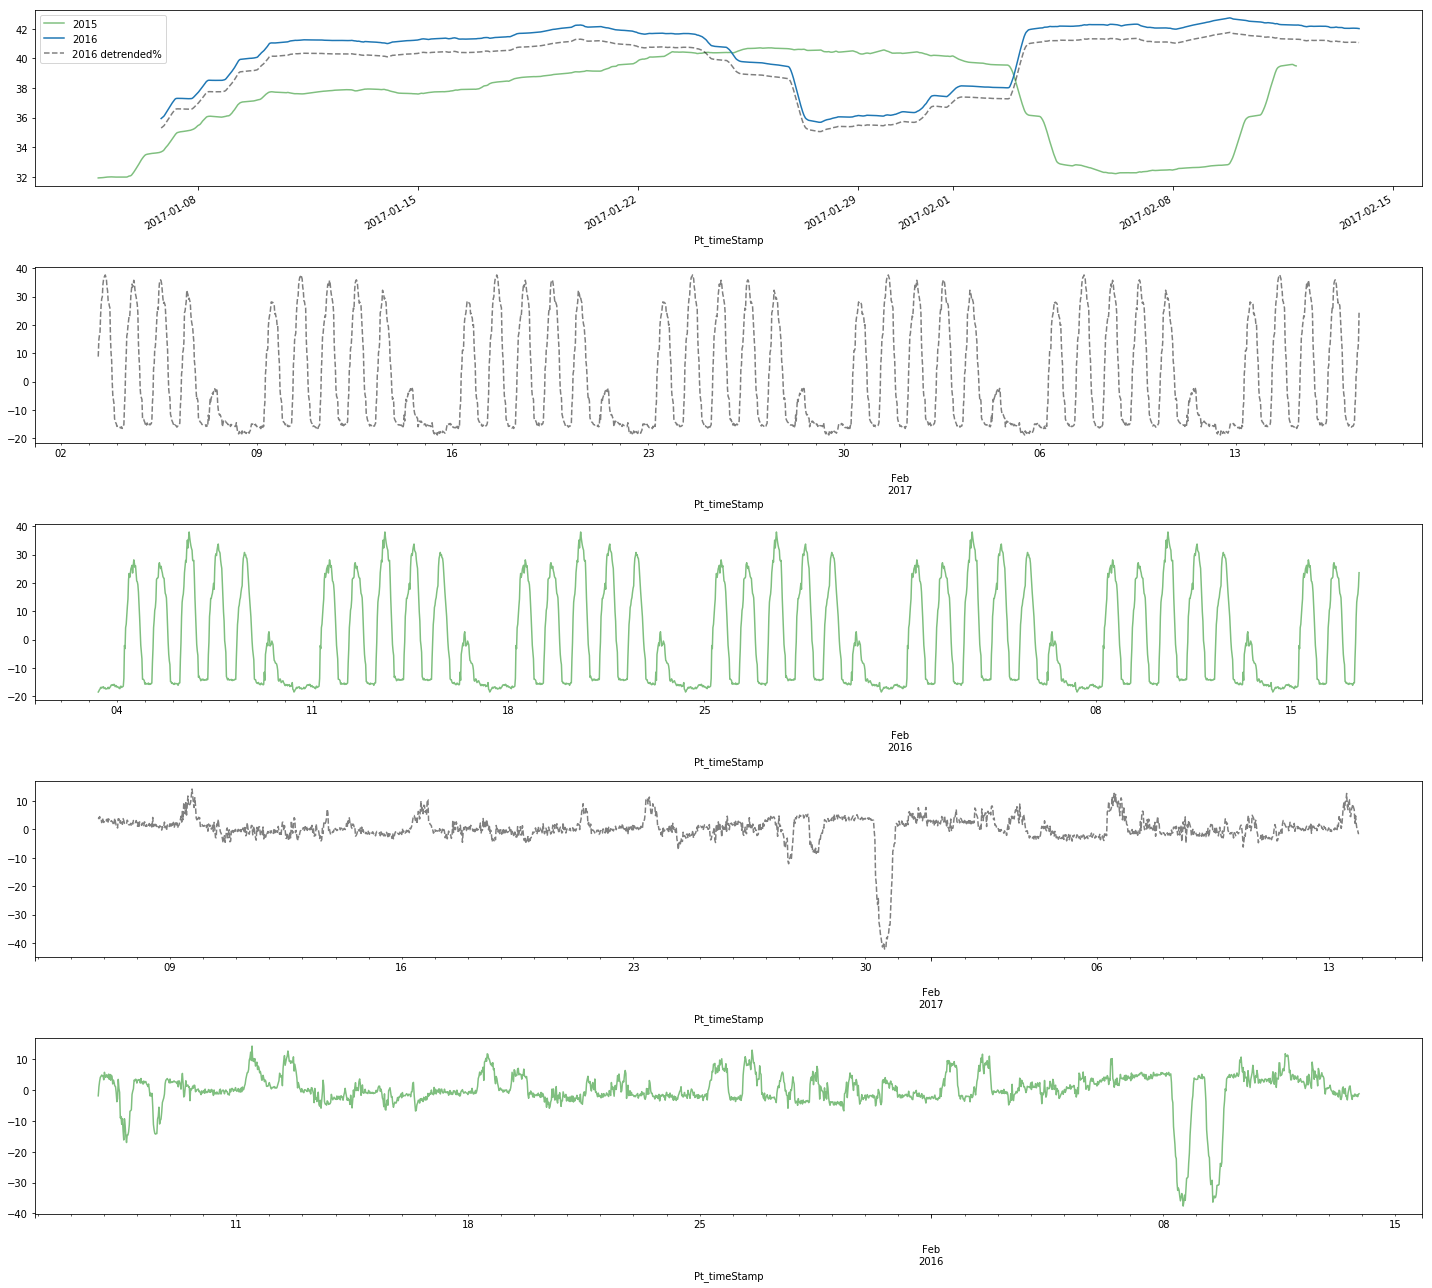

In [56]:
plt.figure(figsize=(20, 18))
plt.subplot(511)
plt.plot(decomp336_1.trend.index + pd.Timedelta('364 days'), decomp336_1.trend, label='2015', color='green', alpha=.5)
# plt.plot(decomp336_mult.trend.index + pd.Timedelta('365 days'), decomp336_mult.trend * 1.15, label='2015 + 15%', color='black', alpha=.5, linestyle='--')
decomp336_val_1.trend.plot(label='2016')
decomp336_val_detrended1.trend.plot(label='2016 detrended%', color='black', alpha=.5, linestyle='--')
plt.legend()
plt.subplot(512)
decomp336_val_detrended1.seasonal.plot(color='black', alpha=.5, linestyle='--')
plt.subplot(513)
decomp336_1.seasonal.plot(color='green', alpha=.5)
plt.subplot(514)
decomp336_val_detrended1.resid.plot(color='black', alpha=.5, linestyle='--')
plt.subplot(515)
decomp336_1.resid.plot(color='green', alpha=.5)
plt.tight_layout()

The detrended 2017 data is more similar to the 2016 data in the period Jan to Apr. The dip in the data is the Chinese New Year period 8-9 Feb 2016 and 28-29 Jan 2017.

### Assume there is a linear trending increase in usage by x%. For the training data from Jul 15 to Dec 16, the data between Aug 16 and Dec 16 needs to be detrended.

In [44]:
detrended = as5_train_df.loc['2016-08-01 00:00:00':, 'PWM_30min_avg']
min = detrended.min()
# detrended = (detrended - min) * .95 + as5_train_df['PWM_30min_avg']['2016-07-31 23:30:00']
detrended = (detrended - min) * .95 + as5_train_df['PWM_30min_avg'].min()
detrended = pd.concat([as5_train_df.loc[:'2016-07-31 23:30:00', 'PWM_30min_avg'], detrended])

to be completed ...

## Look at other building data

In [45]:
bldg_data = mu.load_data_by_bldg(['MRB', 'S1A', 'SDE-2'], 'imputed_train')

In [46]:
print(bldg_data[0][0], bldg_data[1][0], bldg_data[2][0])

MRB S1A SDE-2


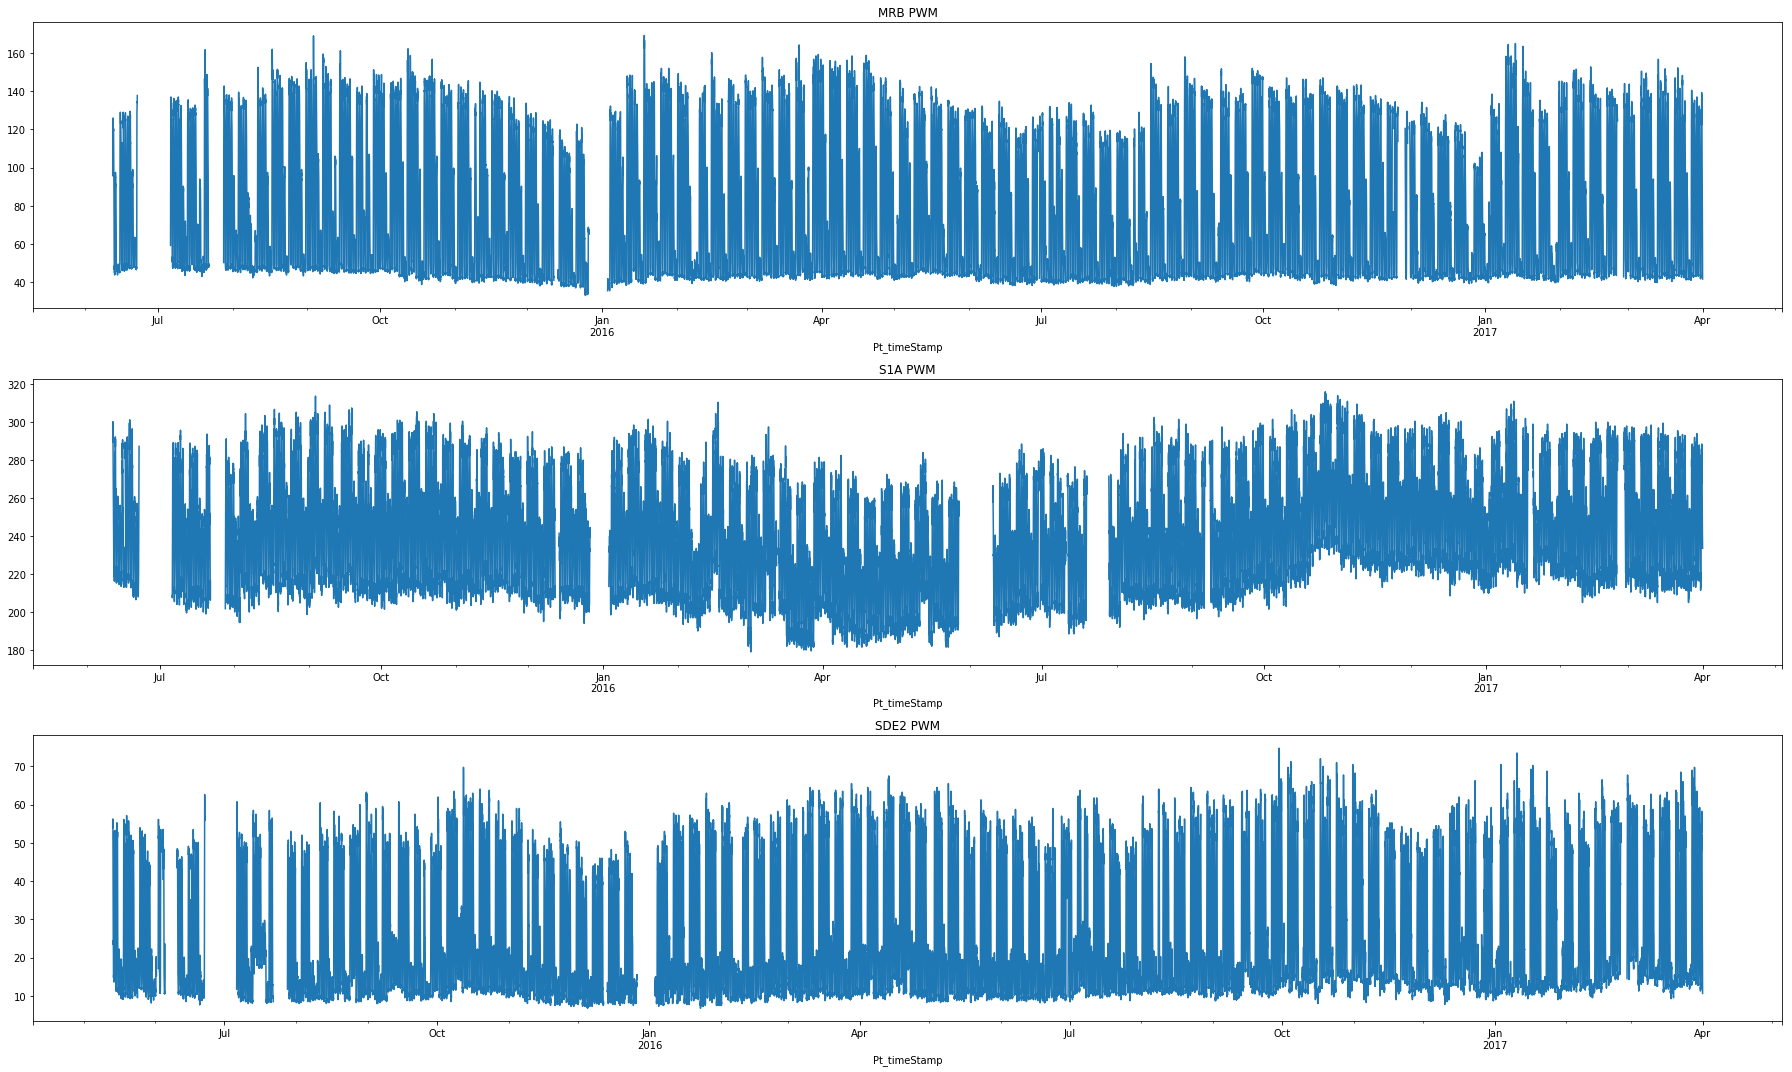

In [47]:
plt.figure(figsize=(25, 15))
mrb_train_df = bldg_data[0][1]
plt.subplot(311)
mrb_train_df['PWM_30min_avg'].plot(title='MRB PWM')
s1a_train_df = bldg_data[1][1]
plt.subplot(312)
s1a_train_df['PWM_30min_avg'].plot(title='S1A PWM')
sde2_train_df = bldg_data[2][1]
plt.subplot(313)
sde2_train_df['PWM_30min_avg'].plot(title='SDE2 PWM')
plt.tight_layout()

The building PWM patterns for MRB looks most regular over time.

In [4]:
processed_bldg_data = mu.load_data_by_bldg(['AS5', 'MRB', 'S1A', 'SDE-2'], 'processed')

In [7]:
print(processed_bldg_data[0][0], processed_bldg_data[1][0], processed_bldg_data[2][0], processed_bldg_data[3][0])

AS5 MRB S1A SDE-2


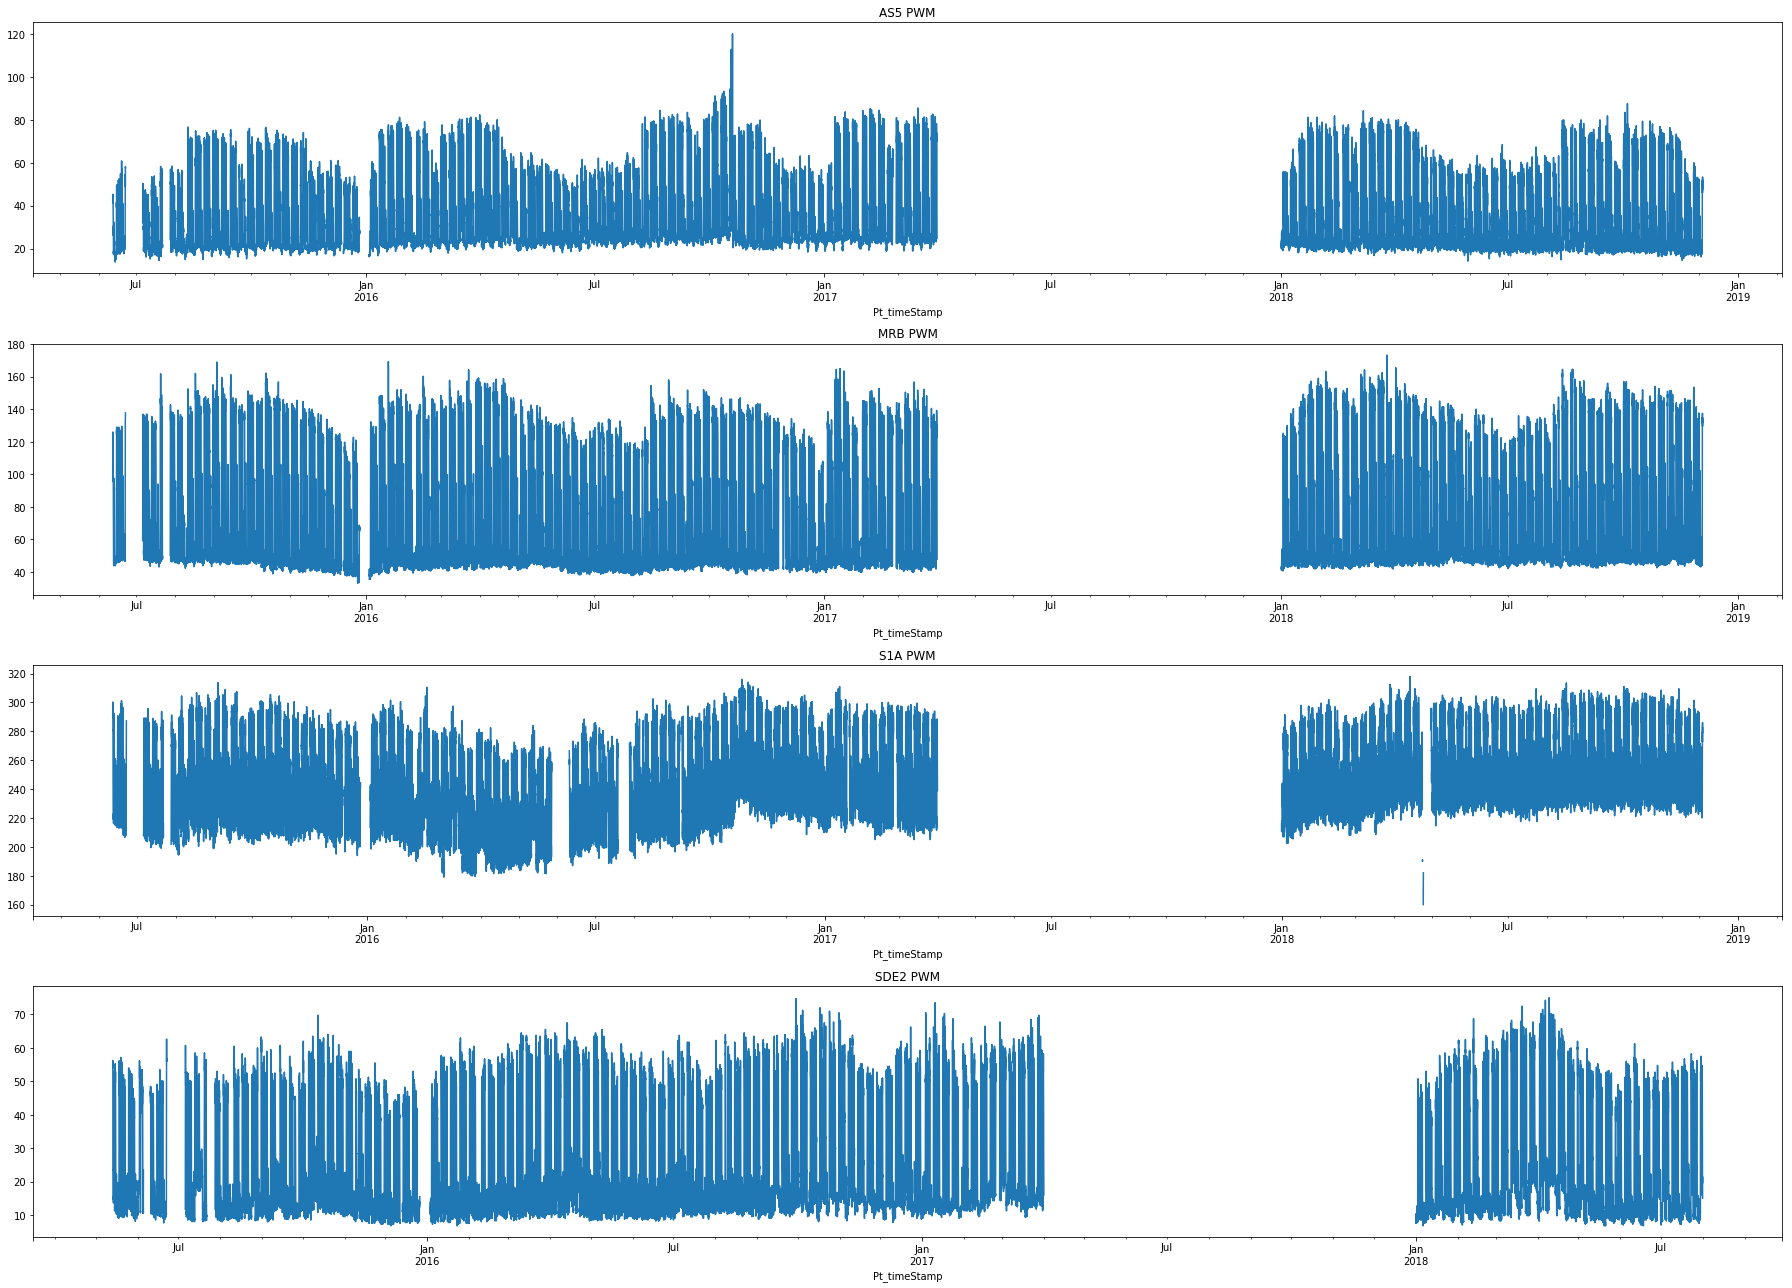

In [9]:
plt.figure(figsize=(25, 18))
plt.subplot(411)
processed_bldg_data[0][1]['PWM_30min_avg'].plot(title='AS5 PWM')
plt.subplot(412)
processed_bldg_data[1][1]['PWM_30min_avg'].plot(title='MRB PWM')
plt.subplot(413)
processed_bldg_data[2][1]['PWM_30min_avg'].plot(title='S1A PWM')
plt.subplot(414)
processed_bldg_data[3][1]['PWM_30min_avg'].plot(title='SDE2 PWM')
plt.tight_layout()